In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import mahotas
import cv2 
import os
import h5py

images_per_class = 800
fixed_size = tuple((500,500))
train_path = "dataset/train/"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'

bins = 8

In [6]:
# Converting image to rgb from bgr format
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return rgb_img

In [7]:
def contrast_enhance(rgb_img):
    r_image, g_image, b_image = cv2.split(rgb_img)
    r_image_en = cv2.equalizeHist(r_image)
    g_image_en = cv2.equalizeHist(g_image)
    b_image_en = cv2.equalizeHist(b_image)

    image_en = cv2.merge((r_image_en, g_image_en, b_image_en))
    return image_en


In [8]:
#Conversion to hsv image formt from rgb
def bgr_hsv(image_en):
    hsv_img = cv2.cvtColor(image_en, cv2.COLOR_RGB2HSV)
    return hsv_img

In [9]:
#image segmentation
#for extraction of green and brown color

def img_segmentation(rgb_img, hsv_img):
    lower_green = np.array([15,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown,upper_brown)
    disease_result = cv2.bitwise_and(rgb_img,rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img,rgb_img, mask = final_mask)
    return final_result

In [10]:
#feature descriptor - 1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [11]:
#feature descriptor - 2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [12]:
#feature descriptor - 3 : Color Histogram

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image],[0,1,2], None,[bins,bins,bins],[0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

In [13]:
#get the training labels

train_labels = os.listdir(train_path)

#sort the training labels

train_labels.sort()
train_dir = 'dataset/train/'
validation_dir = 'dataset/test/'
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (224,224), batch_size = 16, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir,target_size = (224,224), batch_size = 10, class_mode = 'categorical', shuffle = True)
print(train_generator.class_indices)

global_features = []
labels = []


Found 11746 images belonging to 8 classes.
Found 2941 images belonging to 8 classes.
{'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Septoria_leaf_spot': 3, 'Tomato_Spider_mites_Two_spotted_spider_mite': 4, 'Tomato__Target_Spot': 5, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 6, 'Tomato_healthy': 7}


In [14]:
reverse_mapping = ['Tomato_Bacterial_spot', 'Tomato_Early_Blight','Tomato_Late_Blight','Tomato_Septoria_Leafspot','Tomato_Spider_mites', 'Tomato_TargetSpot','Tomato_YellowLeaf', 'Tomato_Healthy']

In [15]:
# loop over the training data sub_folders

for training_name in train_labels:
    #join the training data path and each species training folder

    dir = os.path.join(train_path,training_name)

    #get the current training label

    current_label = training_name

    # loop over the image in eah folder

    for x in range(1, images_per_class+1):
        #get the image filename
        file = dir + "/" + str(x) + ".JPG"

        #read the image and resize it to the fixed size

        image = cv2.imread(file)
        
        image = cv2.resize(image, fixed_size)

        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV)

        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick = fd_haralick(IMG_SEGMENT)
        fv_histogram = fd_histogram(IMG_SEGMENT)

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        labels.append(current_label)
        global_features.append(global_feature)

        print("[STATUS] processed folder : {}".format(current_label))
print("[STATUS] completed Global Feature Extraction...")
        


[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot
[STATUS] processed folder : Tomato_Bacterial_spot


In [16]:
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))
print("[STATUS] training labels {}".format(np.array(labels).shape))

targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...") 

[STATUS] feature vector size (6400, 532)
[STATUS] training labels (6400,)
[STATUS] training labels encoded...


In [17]:
#scale feature in the range (0-1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized ...") 

[STATUS] feature vector normalized ...


In [18]:
#save feature vedtor using hdf5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In [19]:
#training

import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')


num_trees = 100
test_size = 0.20
seed = 9
train_path = 'dataset/train/'
test_path = 'dataset/test/'
h5_train_data = 'output/train_data.h5'
h5_test_datas = 'output/test_datas.h5'
h5_train_labels = 'output/train_labels.h5'
scoring = "accuracy"


#get the training labels

train_labels = os.listdir(train_path)

#sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)


#create all the machine learning models

models = []

models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state= seed)))

#variables to hold the results and names

results = []
names =[]

#import the feature vector and trained labels
h5f_data = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

#verify the shape of the feature vector and labels

print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] label shape: {}".format(global_labels.shape))

print("[STATUS] training started...")
  

[STATUS] features shape: (6400, 532)
[STATUS] label shape: (6400,)
[STATUS] training started...


In [20]:
#split the training and testing data

(trainDataGlobal, testDataGlobal,trainLabelsGlobal,testLabelsGlobal) = train_test_split(np.array(global_features),np.array(global_labels),test_size = test_size, random_state = seed)
trainDataGlobal

array([[9.25697219e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.10422636e-02, 1.73063562e-01, 9.18182611e-01],
       [9.45083877e-01, 1.45349140e-03, 2.21255162e-05, ...,
        1.10429806e-02, 1.73124059e-01, 9.18183071e-01],
       [9.67433568e-01, 3.05948765e-04, 0.00000000e+00, ...,
        1.10430709e-02, 1.73131106e-01, 9.18183538e-01],
       ...,
       [9.74777599e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.09528697e-02, 1.71657237e-01, 9.18461596e-01],
       [9.81014352e-01, 2.57537810e-03, 1.65066271e-04, ...,
        1.10400567e-02, 1.73055078e-01, 9.18174049e-01],
       [9.37396013e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.10426431e-02, 1.73105779e-01, 9.18182498e-01]])

RF: 0.925391 (0.010401)


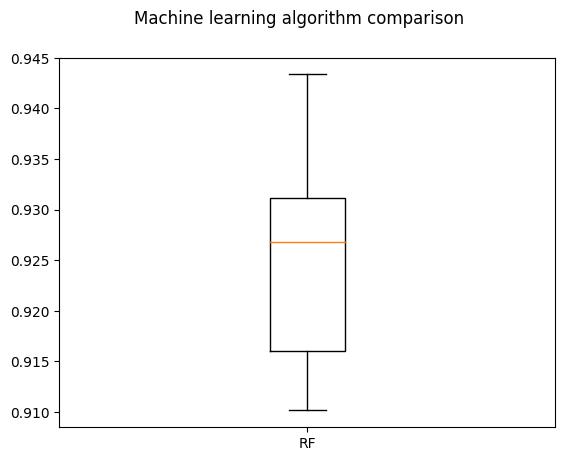

In [21]:
#10-fold cross validation

for name, model in models:
    kfold = KFold(n_splits = 10, random_state = None)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

h5f_test = h5py.File(h5_test_datas, 'w')
h5f_test.create_dataset('dataset_1', data=np.array(global_features))
h5f_test.close()


#boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle("Machine learning algorithm comparison")
ax=fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       154
           1       0.87      0.84      0.85       140
           2       0.95      0.86      0.90       161
           3       0.95      0.95      0.95       174
           4       0.90      0.91      0.91       152
           5       0.81      0.91      0.86       155
           6       0.98      0.96      0.97       179
           7       0.99      0.99      0.99       165

    accuracy                           0.92      1280
   macro avg       0.92      0.92      0.92      1280
weighted avg       0.93      0.92      0.92      1280



0.92421875

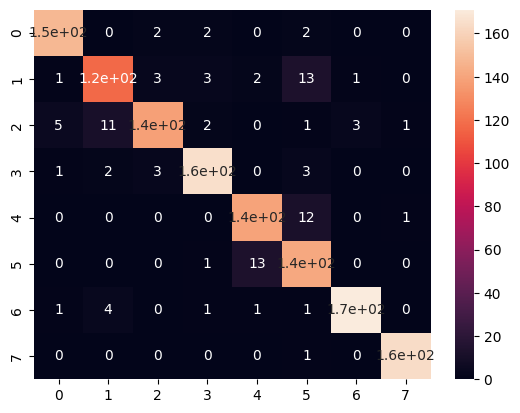

In [22]:
#RF

clf = RandomForestClassifier(random_state = seed)

clf.fit(trainDataGlobal, trainLabelsGlobal)

y_predict = clf.predict(testDataGlobal)
cm = confusion_matrix(testLabelsGlobal, y_predict)
import seaborn as sns
sns.heatmap(cm, annot = True)
print(classification_report(testLabelsGlobal, y_predict))
accuracy_score(testLabelsGlobal, y_predict)




In [23]:
h5f_data = h5py.File(h5_test_datas, 'r')

test_features_string = h5f_data['dataset_1']

test_features = np.array(test_features_string)

h5f_data.close()

In [24]:
#test an image
import cv2
import matplotlib.pyplot as plt
# model = load_model("output/test_datas.h5")



sam = 'dataset/test/Tomato__Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG'
img = plt.imread(sam)


def ready(file):
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    RGB_BGR = rgb_bgr(image)
   
    BGR_HSV = bgr_hsv(RGB_BGR)
    IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV)
    fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
    fv_haralick = fd_haralick(IMG_SEGMENT)
    fv_histogram = fd_histogram(IMG_SEGMENT)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    global_feature=np.expand_dims(global_feature, axis=0)

    return global_feature


imag=ready(sam)
disease = clf.predict(imag)
prediction = disease[0]
print(prediction)

prediction_name = reverse_mapping[prediction]
prediction_name


5


'Tomato_TargetSpot'

Actual: Tomato__Target_Spot
Predicted: Tomato_TargetSpot


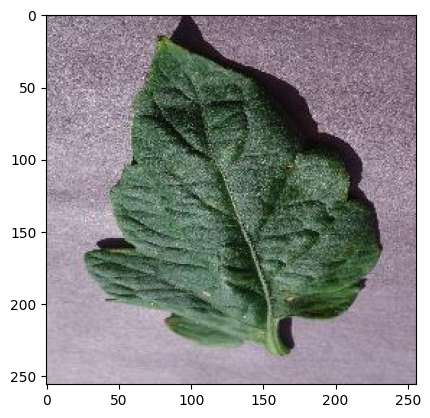

In [25]:
path=os.path.dirname(sam)
label=os.path.basename(path)
print("Actual: " + label)
print("Predicted: " + prediction_name)

plt.imshow(img)
plt.show()

In [31]:
history = model.fit(trainDataGlobal, trainLabelsGlobal,

epochs = 100,
batch_size = 16,
validation_data = (testDataGlobal, testLabelsGlobal)
)

model.save('output/test_data.h5')

TypeError: fit() got an unexpected keyword argument 'epochs'